# Import Libraries

In [1]:
#LSTM for regression
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import sqrt
import tensorflow as tf
import sklearn
import seaborn as sns
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import asarray
from sklearn.ensemble import RandomForestRegressor
from pandas import concat
from sklearn.model_selection import train_test_split

# Data Pre-Processing

In [2]:
coffee_data = pd.read_excel('coffee_data.xlsx')
fuel_data = pd.read_excel('fuel_data.xlsx')
#tomato_data = pd.read_excel('tomato_data.xls')

### Filter Coffee data

In [3]:
coffee_data['Ngày'] = pd.to_datetime(coffee_data['Ngày'])
coffee_data['Giá Cà Phê'] =  coffee_data['Giá']
coffee_data.drop(coffee_data.columns[[0, 1, 2, 3, 5]], axis=1, inplace=True)
coffee_data.head(5)

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-04,32717.0
2,2021-01-05,32417.0
3,2021-01-06,32317.0
4,2021-01-07,32117.0


### Filter Tomato data

In [4]:
# tomato_data['Ngày'] = pd.to_datetime(tomato_data['Ngày tháng'])
# tomato_data.drop(tomato_data.columns[[0, 1, 2, 3, 5]], axis=1, inplace=True)
# tomato_data.head(5)

### Filter Diesel data

In [5]:
fuel_data["Ngày"] = pd.to_datetime(fuel_data["Giá nhiên liệu"], format="%d.%m.%Y")
fuel_data.drop(fuel_data.columns[[0,1,2,4]], axis='columns', inplace=True)
# reverse the order
fuel_data = fuel_data[::-1]
fuel_data.head(5)

,Dầu Diesel 1 lít,Ngày
118,14.90,2019-01-01
117,14.90,2019-01-16
116,14.90,2019-01-31
115,14.90,2019-02-15
114,15.86,2019-03-02


### Merge Data

In [6]:
# # # daterng_all = pd.date_range(start=fuel_data['Ngày'].iloc[-1], end=fuel_data['Ngày'].iloc[0], freq="1D")
# fuel_data = fuel_data.set_index('Ngày').resample('D').ffill().reset_index()

In [7]:
# Merge the dataframes with an outer join
merged_df = pd.merge(coffee_data, fuel_data, left_on='Ngày', right_on='Ngày', how="outer")

# Fill missing dates from both datasets with each other
merged_df.fillna(method='bfill', inplace=True)
# merged_df['Giá'].fillna(method='ffill', inplace=True)

# Drop one of the duplicated date columns
# merged_df.drop('Ngày', axis=1, inplace=True)

In [8]:
# data = pd.merge(coffee_data, fuel_data, on = 'Ngày', how = "left")
# data['Dầu Diesel 1 lít'].interpolate(method='nearest')

In [9]:
merged_df

,Ngày,Giá Cà Phê,Dầu Diesel 1 lít
0,2021-01-01,31667.5,12.64
1,2021-01-04,32717.0,12.64
2,2021-01-05,32417.0,12.64
3,2021-01-06,32317.0,12.64
4,2021-01-07,32117.0,12.64
...,...,...,...
676,2021-12-25,NaN,17.57
677,2023-01-01,NaN,22.15
678,2023-05-22,NaN,17.95
679,2023-06-01,NaN,17.94


In [10]:
merged_df.dropna()

,Ngày,Giá Cà Phê,Dầu Diesel 1 lít
0,2021-01-01,31667.5,12.64
1,2021-01-04,32717.0,12.64
2,2021-01-05,32417.0,12.64
3,2021-01-06,32317.0,12.64
4,2021-01-07,32117.0,12.64
...,...,...,...
619,2023-05-15,55566.5,14.90
620,2023-05-16,56066.5,14.90
621,2023-05-17,56666.5,14.90
622,2023-05-18,57000.0,14.90


In [11]:
#data = pd.merge(merged_df, tomato_data, left_on='Ngày', right_on='Ngày', how = "outer")

In [12]:
data = merged_df

In [13]:
#convert to float
data['Giá Cà Phê'].astype(float)
data['Dầu Diesel 1 lít'].astype(float)

0      12.64
1      12.64
2      12.64
3      12.64
4      12.64
       ...  
676    17.57
677    22.15
678    17.95
679    17.94
680    18.02
Name: Dầu Diesel 1 lít, Length: 681, dtype: float64

# Data Visualization

<AxesSubplot:ylabel='Frequency'>

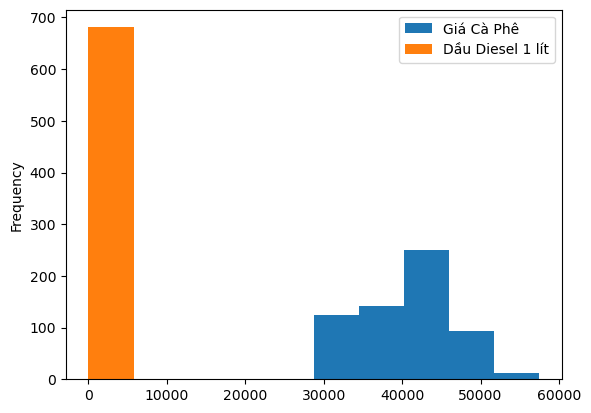

In [14]:
data.plot.hist()

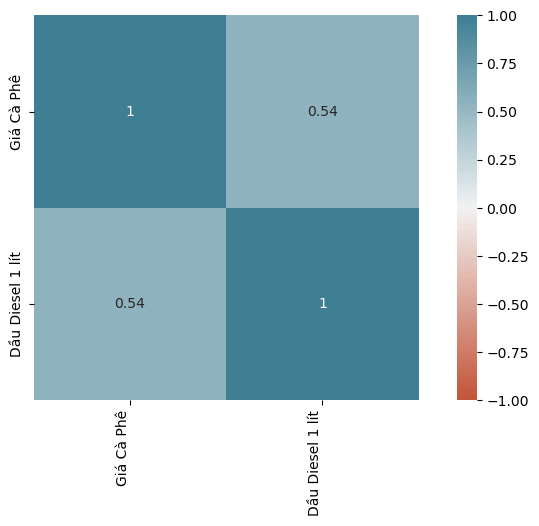

In [15]:
# # Use heatmap to identify correlation between variables
f, ax = plt.subplots(figsize = (10, 5))
corr = data.corr()
ax = sns.heatmap(
    corr, vmin = -1, vmax = 1, center = 0, annot = True,
    cmap = sns.diverging_palette(20, 220, n = 200),
    square = True
)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, horizontalalignment = 'right');

In [16]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Normalization

In [17]:
# drop date column
data.drop(data.columns[[0]], axis=1, inplace=True)
data.dropna()

,Giá Cà Phê,Dầu Diesel 1 lít
0,31667.5,12.64
1,32717.0,12.64
2,32417.0,12.64
3,32317.0,12.64
4,32117.0,12.64
...,...,...
619,55566.5,14.90
620,56066.5,14.90
621,56666.5,14.90
622,57000.0,14.90


In [18]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
# load dataset
values = data.values
values

array([[3.16675e+04, 1.26400e+01],
       [3.27170e+04, 1.26400e+01],
       [3.24170e+04, 1.26400e+01],
       ...,
       [        nan, 1.79500e+01],
       [        nan, 1.79400e+01],
       [        nan, 1.80200e+01]])

In [20]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [21]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var1(t),var2(t)
1,0.022718,0.138393,0.062422,0.138393
2,0.062422,0.138393,0.051073,0.138393
3,0.051073,0.138393,0.047289,0.138393
4,0.047289,0.138393,0.039723,0.138393
5,0.039723,0.138393,0.028374,0.138393
...,...,...,...,...
619,0.868214,0.250496,0.926853,0.250496
620,0.926853,0.250496,0.945769,0.250496
621,0.945769,0.250496,0.968467,0.250496
622,0.968467,0.250496,0.981084,0.250496


In [22]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)
dataset = reframed
print(dataset.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.022718   0.138393  0.062422
2   0.062422   0.138393  0.051073
3   0.051073   0.138393  0.047289
4   0.047289   0.138393  0.039723
5   0.039723   0.138393  0.028374


# Split data

In [23]:
dataset = reframed.values

# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]

print(len(train), len(test))

498 125


In [24]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(498, 1, 2) (498,) (125, 1, 2) (125,)


# Train Model

Epoch 1/30
32/32 - 1s - loss: 0.1943 - val_loss: 0.3411 - 1s/epoch - 37ms/step
Epoch 2/30
32/32 - 0s - loss: 0.1221 - val_loss: 0.2119 - 42ms/epoch - 1ms/step
Epoch 3/30
32/32 - 0s - loss: 0.0846 - val_loss: 0.1763 - 41ms/epoch - 1ms/step
Epoch 4/30
32/32 - 0s - loss: 0.0789 - val_loss: 0.1777 - 41ms/epoch - 1ms/step
Epoch 5/30
32/32 - 0s - loss: 0.0742 - val_loss: 0.1688 - 41ms/epoch - 1ms/step
Epoch 6/30
32/32 - 0s - loss: 0.0686 - val_loss: 0.1468 - 41ms/epoch - 1ms/step
Epoch 7/30
32/32 - 0s - loss: 0.0619 - val_loss: 0.1380 - 43ms/epoch - 1ms/step
Epoch 8/30
32/32 - 0s - loss: 0.0549 - val_loss: 0.1191 - 42ms/epoch - 1ms/step
Epoch 9/30
32/32 - 0s - loss: 0.0470 - val_loss: 0.0944 - 42ms/epoch - 1ms/step
Epoch 10/30
32/32 - 0s - loss: 0.0380 - val_loss: 0.0771 - 44ms/epoch - 1ms/step
Epoch 11/30
32/32 - 0s - loss: 0.0290 - val_loss: 0.0489 - 43ms/epoch - 1ms/step
Epoch 12/30
32/32 - 0s - loss: 0.0214 - val_loss: 0.0327 - 42ms/epoch - 1ms/step
Epoch 13/30
32/32 - 0s - loss: 0.0170 

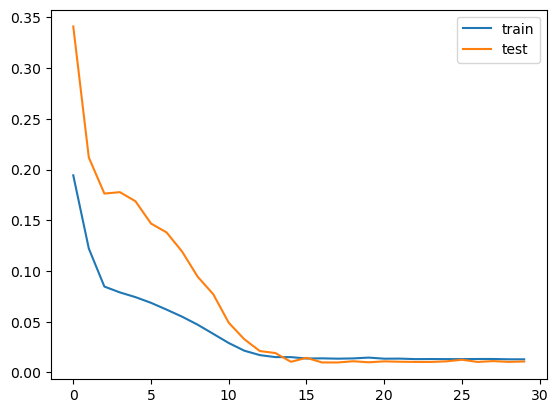

In [25]:
from matplotlib import pyplot

# design network
model = Sequential()
model.add(LSTM(15, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=16, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=True)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Results Analysis

In [26]:
# calculate metrics
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = sklearn.metrics.mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

def print_metrics(test, pre_test):
    
    print('\nRMSE')
    testScore = np.sqrt(mean_squared_error(test,pre_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    print('\nMAE')
    testScore = sklearn.metrics.mean_absolute_error(test, pre_test)
    print('Test Score: %.2f MAE' % (testScore))
    
    print('\nMAPE')                          
    testScore = sklearn.metrics.mean_absolute_percentage_error(test, pre_test)
    print('Test Score: %.2f MAPE' % (testScore))
    
    print('\nMASE')
    testScore = mean_absolute_scaled_error(test, pre_test, test)
    print('Test Score: %.2f MASE' % (testScore))

In [27]:
# make a prediction
test_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

4/4 [==============================] - 0s 833us/step


In [28]:
# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X[:, 1:]), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [29]:
# print results
print_metrics(inv_y, inv_test_pred)


RMSE
Test Score: 386.90 RMSE

MAE
Test Score: 283.45 MAE

MAPE
Test Score: 0.01 MAPE

MASE
Test Score: 1.05 MASE


# --------------------------------------------------------------------------------------------------------

# LSTM

In [30]:
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)

In [31]:
# # reshape into X=t and Y=t+1
# look_back = 1
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

In [32]:
# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [33]:
# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)

In [34]:
# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [35]:
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)  
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

In [36]:
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()